In [1]:
#A lot of the preprocessing is based on Dieter's and Theio Vial's work.
#https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings
#https://www.kaggle.com/theoviel/improve-your-score-with-some-text-preprocessing

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
#from wordcloud import WordCloud, STOPWORDS
import pyprind 
import warnings
warnings.filterwarnings('ignore')
import gc
import gensim
from gensim.models import KeyedVectors
import operator
import string
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/quora-insincere-questions-classification/train.csv
/kaggle/input/quora-insincere-questions-classification/sample_submission.csv
/kaggle/input/quora-insincere-questions-classification/test.csv
/kaggle/input/quora-insincere-questions-classification/embeddings/paragram_300_sl999/paragram_300_sl999.txt
/kaggle/input/quora-insincere-questions-classification/embeddings/paragram_300_sl999/README.txt
/kaggle/input/quora-insincere-questions-classification/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec
/kaggle/input/quora-insincere-questions-classification/embeddings/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin
/kaggle/input/quora-insincere-questions-classification/embeddings/glove.840B.300d/glove.840B.300d.txt


In [3]:
train = pd.read_csv('../input/quora-insincere-questions-classification/train.csv', encoding='utf-8')#.drop('target',axis=1)
test = pd.read_csv('../input/quora-insincere-questions-classification/test.csv', encoding='utf-8')
df = pd.concat([train,test],axis=0)
print(f'''Train Shape: {train.shape}
Test Shape: {test.shape}
Df Shape:{df.shape}''')

Train Shape: (1306122, 3)
Test Shape: (375806, 2)
Df Shape:(1681928, 3)


In [4]:
train = train.sample(frac=1)
print(f'Train Shape:{train.shape}')

Train Shape:(1306122, 3)


In [5]:
def build_vocab(sentences, verbose=True):
    sentences = sentences.apply(lambda x: x.split()).values
    vocab={}    
    for sentence in pyprind.prog_bar(sentences):
        for word in sentence:
            try:
                vocab[word]+=1
            except KeyError:
                vocab[word]=1
    return vocab          

In [6]:
def load_embed(file):
    def get_coefs(word,*arr): 
        #print(word,arr)
        return word, np.asarray(arr, dtype='float16')
    
    if file == '../input/quora-insincere-questions-classification/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec':
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding='utf8') if len(o)>100)
    elif file == '../input/quora-insincere-questions-classification/embeddings/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin':
        embeddings_index = KeyedVectors.load_word2vec_format(file, binary=True)
    elif file == '../input/quora-insincere-questions-classification/embeddings/paragram_300_sl999/paragram_300_sl999.txt':
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding='latin') if len(o)>100)
    else:
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding='latin'))
        
    return embeddings_index
glove = '../input/quora-insincere-questions-classification/embeddings/glove.840B.300d/glove.840B.300d.txt'
paragram =  '../input/quora-insincere-questions-classification/embeddings/paragram_300_sl999/paragram_300_sl999.txt'
#wiki_news = '../input/quora-insincere-questions-classification/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec'

In [7]:
#print("Extracting GloVe embedding")
#embed_glove = load_embed(glove)
print("Extracting Paragram embedding")
embed_paragram = load_embed(paragram)
#print("Extracting FastText embedding")
#embed_fasttext = load_embed(wiki_news)

Extracting Paragram embedding


In [8]:
def check_coverage(vocab,embeddings_index):
    known_words={}
    unknown_words={}
    nb_known_words=0
    nb_unknown_words=0
    for word in vocab.keys():
        if word in embeddings_index.keys():
            known_words[word]=embeddings_index[word]
            nb_known_words += vocab[word]
        elif word.capitalize() in embeddings_index.keys():
            known_words[word] = embeddings_index[word.capitalize()]
            nb_known_words += vocab[word]
        elif word.lower() in embeddings_index.keys():
            known_words[word] = embeddings_index[word.lower()]
            nb_known_words += vocab[word]
        elif word.upper() in embeddings_index.keys():
            known_words[word] = embeddings_index[word.upper()]
            nb_known_words += vocab[word]
        else:
            unknown_words[word] = vocab[word]
            nb_unknown_words += vocab[word]
    print(f'Found embeddings for {round((len(known_words)/len(vocab))*100,5)}% of the vocab\nFound embeddings for {round((nb_known_words/(nb_known_words+nb_unknown_words))*100,5)}% of all text')
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1),reverse=True)#[::-1]
    return unknown_words

In [9]:
# vocab = build_vocab(df['question_text'])

In [10]:
# print("Glove : ")
# oov_glove = check_coverage(vocab, embed_glove)
# print("Paragram : ")
# oov_paragram = check_coverage(vocab, embed_paragram)
# #print("FastText : ")
# #oov_fasttext = check_coverage(vocab, embed_fasttext)

In [11]:
contraction_mapping = {
    "Trump's" : 'trump is',"'cause": 'because','â€™': "'",',cause': 'because',';cause': 'because',"ain't": 'am not','ain,t': 'am not',
    'ain;t': 'am not','ain´t': 'am not','ain’t': 'am not',"aren't": 'are not','â€“': '-','â€œ':'"',
    'aren,t': 'are not','aren;t': 'are not','aren´t': 'are not','aren’t': 'are not',"can't": 'cannot',"can't've": 'cannot have','can,t': 'cannot','can,t,ve': 'cannot have',
    'can;t': 'cannot','can;t;ve': 'cannot have',
    'can´t': 'cannot','can´t´ve': 'cannot have','can’t': 'cannot','can’t’ve': 'cannot have',
    "could've": 'could have','could,ve': 'could have','could;ve': 'could have',"couldn't": 'could not',"couldn't've": 'could not have','couldn,t': 'could not','couldn,t,ve': 'could not have','couldn;t': 'could not',
    'couldn;t;ve': 'could not have','couldn´t': 'could not',
    'couldn´t´ve': 'could not have','couldn’t': 'could not','couldn’t’ve': 'could not have','could´ve': 'could have',
    'could’ve': 'could have',"didn't": 'did not','didn,t': 'did not','didn;t': 'did not','didn´t': 'did not',
    'didn’t': 'did not',"doesn't": 'does not','doesn,t': 'does not','doesn;t': 'does not','doesn´t': 'does not',
    'doesn’t': 'does not',"don't": 'do not','don,t': 'do not','don;t': 'do not','don´t': 'do not','don’t': 'do not',
    "hadn't": 'had not',"hadn't've": 'had not have','hadn,t': 'had not','hadn,t,ve': 'had not have','hadn;t': 'had not',
    'hadn;t;ve': 'had not have','hadn´t': 'had not','hadn´t´ve': 'had not have','hadn’t': 'had not','hadn’t’ve': 'had not have',"hasn't": 'has not','hasn,t': 'has not','hasn;t': 'has not','hasn´t': 'has not','hasn’t': 'has not',
    "haven't": 'have not','haven,t': 'have not','haven;t': 'have not','haven´t': 'have not','haven’t': 'have not',"he'd": 'he would',
    "he'd've": 'he would have',"he'll": 'he will',
    "he's": 'he is','he,d': 'he would','he,d,ve': 'he would have','he,ll': 'he will','he,s': 'he is','he;d': 'he would',
    'he;d;ve': 'he would have','he;ll': 'he will','he;s': 'he is','he´d': 'he would','he´d´ve': 'he would have','he´ll': 'he will',
    'he´s': 'he is','he’d': 'he would','he’d’ve': 'he would have','he’ll': 'he will','he’s': 'he is',"how'd": 'how did',"how'll": 'how will',
    "how's": 'how is','how,d': 'how did','how,ll': 'how will','how,s': 'how is','how;d': 'how did','how;ll': 'how will',
    'how;s': 'how is','how´d': 'how did','how´ll': 'how will','how´s': 'how is','how’d': 'how did','how’ll': 'how will',
    'how’s': 'how is',"i'd": 'i would',"i'll": 'i will',"i'm": 'i am',"i've": 'i have','i,d': 'i would','i,ll': 'i will',
    'i,m': 'i am','i,ve': 'i have','i;d': 'i would','i;ll': 'i will','i;m': 'i am','i;ve': 'i have',"isn't": 'is not',
    'isn,t': 'is not','isn;t': 'is not','isn´t': 'is not','isn’t': 'is not',"it'd": 'it would',"it'll": 'it will',"It's":'it is',
    "it's": 'it is','it,d': 'it would','it,ll': 'it will','it,s': 'it is','it;d': 'it would','it;ll': 'it will','it;s': 'it is','it´d': 'it would','it´ll': 'it will','it´s': 'it is',
    'it’d': 'it would','it’ll': 'it will','it’s': 'it is',
    'i´d': 'i would','i´ll': 'i will','i´m': 'i am','i´ve': 'i have','i’d': 'i would','i’ll': 'i will','i’m': 'i am',
    'i’ve': 'i have',"let's": 'let us','let,s': 'let us','let;s': 'let us','let´s': 'let us',
    'let’s': 'let us',"ma'am": 'madam','ma,am': 'madam','ma;am': 'madam',"mayn't": 'may not','mayn,t': 'may not','mayn;t': 'may not',
    'mayn´t': 'may not','mayn’t': 'may not','ma´am': 'madam','ma’am': 'madam',"might've": 'might have','might,ve': 'might have','might;ve': 'might have',"mightn't": 'might not','mightn,t': 'might not','mightn;t': 'might not','mightn´t': 'might not',
    'mightn’t': 'might not','might´ve': 'might have','might’ve': 'might have',"must've": 'must have','must,ve': 'must have','must;ve': 'must have',
    "mustn't": 'must not','mustn,t': 'must not','mustn;t': 'must not','mustn´t': 'must not','mustn’t': 'must not','must´ve': 'must have',
    'must’ve': 'must have',"needn't": 'need not','needn,t': 'need not','needn;t': 'need not','needn´t': 'need not','needn’t': 'need not',"oughtn't": 'ought not','oughtn,t': 'ought not','oughtn;t': 'ought not',
    'oughtn´t': 'ought not','oughtn’t': 'ought not',"sha'n't": 'shall not','sha,n,t': 'shall not','sha;n;t': 'shall not',"shan't": 'shall not',
    'shan,t': 'shall not','shan;t': 'shall not','shan´t': 'shall not','shan’t': 'shall not','sha´n´t': 'shall not','sha’n’t': 'shall not',
    "she'd": 'she would',"she'll": 'she will',"she's": 'she is','she,d': 'she would','she,ll': 'she will',
    'she,s': 'she is','she;d': 'she would','she;ll': 'she will','she;s': 'she is','she´d': 'she would','she´ll': 'she will',
    'she´s': 'she is','she’d': 'she would','she’ll': 'she will','she’s': 'she is',"should've": 'should have','should,ve': 'should have','should;ve': 'should have',
    "shouldn't": 'should not','shouldn,t': 'should not','shouldn;t': 'should not','shouldn´t': 'should not','shouldn’t': 'should not','should´ve': 'should have',
    'should’ve': 'should have',"that'd": 'that would',"that's": 'that is','that,d': 'that would','that,s': 'that is','that;d': 'that would',
    'that;s': 'that is','that´d': 'that would','that´s': 'that is','that’d': 'that would','that’s': 'that is',"there'd": 'there had',
    "there's": 'there is','there,d': 'there had','there,s': 'there is','there;d': 'there had','there;s': 'there is',
    'there´d': 'there had','there´s': 'there is','there’d': 'there had','there’s': 'there is',
    "they'd": 'they would',"they'll": 'they will',"they're": 'they are',"they've": 'they have',
    'they,d': 'they would','they,ll': 'they will','they,re': 'they are','they,ve': 'they have','they;d': 'they would','they;ll': 'they will','they;re': 'they are',
    'they;ve': 'they have','they´d': 'they would','they´ll': 'they will','they´re': 'they are','they´ve': 'they have','they’d': 'they would','they’ll': 'they will',
    'they’re': 'they are','they’ve': 'they have',"wasn't": 'was not','wasn,t': 'was not','wasn;t': 'was not','wasn´t': 'was not',
    'wasn’t': 'was not',"we'd": 'we would',"we'll": 'we will',"we're": 'we are',"we've": 'we have','we,d': 'we would','we,ll': 'we will',
    'we,re': 'we are','we,ve': 'we have','we;d': 'we would','we;ll': 'we will','we;re': 'we are','we;ve': 'we have',
    "weren't": 'were not','weren,t': 'were not','weren;t': 'were not','weren´t': 'were not','weren’t': 'were not','we´d': 'we would','we´ll': 'we will',
    'we´re': 'we are','we´ve': 'we have','we’d': 'we would','we’ll': 'we will','we’re': 'we are','we’ve': 'we have',"what'll": 'what will',"what're": 'what are',"what's": 'what is',
    "what've": 'what have','what,ll': 'what will','what,re': 'what are','what,s': 'what is','what,ve': 'what have','what;ll': 'what will','what;re': 'what are',
    'what;s': 'what is','what;ve': 'what have','what´ll': 'what will',
    'what´re': 'what are','what´s': 'what is','what´ve': 'what have','what’ll': 'what will','what’re': 'what are','what’s': 'what is',
    'what’ve': 'what have',"where'd": 'where did',"where's": 'where is','where,d': 'where did','where,s': 'where is','where;d': 'where did',
    'where;s': 'where is','where´d': 'where did','where´s': 'where is','where’d': 'where did','where’s': 'where is',
    "who'll": 'who will',"who's": 'who is','who,ll': 'who will','who,s': 'who is','who;ll': 'who will','who;s': 'who is',
    'who´ll': 'who will','who´s': 'who is','who’ll': 'who will','who’s': 'who is',"won't": 'will not','won,t': 'will not','won;t': 'will not',
    'won´t': 'will not','won’t': 'will not',"wouldn't": 'would not','wouldn,t': 'would not','wouldn;t': 'would not','wouldn´t': 'would not',
    'wouldn’t': 'would not',"you'd": 'you would',"you'll": 'you will',"you're": 'you are','you,d': 'you would','you,ll': 'you will',
    'you,re': 'you are','you;d': 'you would','you;ll': 'you will',
    'you;re': 'you are','you´d': 'you would','you´ll': 'you will','you´re': 'you are','you’d': 'you would','you’ll': 'you will','you’re': 'you are',
    '´cause': 'because','’cause': 'because',"you've": "you have","could'nt": 'could not',
    "havn't": 'have not',"here’s": "here is",'i""m': 'i am',"i'am": 'i am',"i'l": "i will","i'v": 'i have',"wan't": 'want',"was'nt": "was not","who'd": "who would",
    "who're": "who are","who've": "who have","why'd": "why would","would've": "would have","y'all": "you all","y'know": "you know","you.i": "you i",
    "your'e": "you are","arn't": "are not","agains't": "against","c'mon": "common","doens't": "does not",'don""t': "do not","dosen't": "does not",
    "dosn't": "does not","shoudn't": "should not","that'll": "that will","there'll": "there will","there're": "there are",
    "this'll": "this all","u're": "you are", "ya'll": "you all","you'r": "you are","you’ve": "you have","d'int": "did not","did'nt": "did not","din't": "did not","dont't": "do not","gov't": "government",
    "i'ma": "i am","is'nt": "is not","‘I":'I','ᴀɴᴅ':'and','ᴛʜᴇ':'the','ʜᴏᴍᴇ':'home','ᴜᴘ':'up','ʙʏ':'by','ᴀᴛ':'at','…and':'and','civilbeat':'civil beat','TrumpCare':'Trump care','Trumpcare':'Trump care', 'OBAMAcare':'Obama care','ᴄʜᴇᴄᴋ':'check','ғᴏʀ':'for','ᴛʜɪs':'this','ᴄᴏᴍᴘᴜᴛᴇʀ':'computer','ᴍᴏɴᴛʜ':'month','ᴡᴏʀᴋɪɴɢ':'working','ᴊᴏʙ':'job','ғʀᴏᴍ':'from','Sᴛᴀʀᴛ':'start','gubmit':'submit','CO₂':'carbon dioxide','ғɪʀsᴛ':'first','ᴇɴᴅ':'end','ᴄᴀɴ':'can','ʜᴀᴠᴇ':'have','ᴛᴏ':'to','ʟɪɴᴋ':'link','ᴏғ':'of','ʜᴏᴜʀʟʏ':'hourly','ᴡᴇᴇᴋ':'week','ᴇɴᴅ':'end','ᴇxᴛʀᴀ':'extra','Gʀᴇᴀᴛ':'great','sᴛᴜᴅᴇɴᴛs':'student','sᴛᴀʏ':'stay','ᴍᴏᴍs':'mother','ᴏʀ':'or','ᴀɴʏᴏɴᴇ':'anyone','ɴᴇᴇᴅɪɴɢ':'needing','ᴀɴ':'an','ɪɴᴄᴏᴍᴇ':'income',
    'ʀᴇʟɪᴀʙʟᴇ':'reliable','ғɪʀsᴛ':'first','ʏᴏᴜʀ':'your','sɪɢɴɪɴɢ':'signing','ʙᴏᴛᴛᴏᴍ':'bottom','ғᴏʟʟᴏᴡɪɴɢ':'following','Mᴀᴋᴇ':'make',
    'ᴄᴏɴɴᴇᴄᴛɪᴏɴ':'connection','ɪɴᴛᴇʀɴᴇᴛ':'internet','financialpost':'financial post', 'ʜaᴠᴇ':' have ', 'ᴄaɴ':' can ', 'Maᴋᴇ':' make ', 'ʀᴇʟɪaʙʟᴇ':' reliable ', 'ɴᴇᴇᴅ':' need ',
    'ᴏɴʟʏ':' only ', 'ᴇxᴛʀa':' extra ', 'aɴ':' an ', 'aɴʏᴏɴᴇ':' anyone ', 'sᴛaʏ':' stay ', 'Sᴛaʀᴛ':' start', 'SHOPO':'shop',
    }

In [12]:
bar = pyprind.ProgBar(df.shape[0], bar_char='█')
def clean_contractions(text, mapping):
    #text_val = text.lower()
    #map_val = 
    for word in mapping.keys():
        word_val = word.lower()
        if word in text:
            text = text.replace(word, mapping[word])
        elif word_val in text:
            text = text.replace(word_val, mapping[word])
#         elif word.lower() in text:
#             text = text.replace(word, mapping[word])
#         elif word.capitalize() in text:
#             text = text.replace(word, mapping[word])
#         elif word.upper() in text:
#             text = text.replace(word, mapping[word])

    bar.update()
    return text
#df['lowered_question'] = df['question_text'].apply(lambda x: x.lower())
#df['treated_question'] = df['lowered_question'].apply(lambda x: clean_contractions(x, contraction_mapping))
#train['lowered_question'] = train['question_text'].apply(lambda x: x.lower())
#test['lowered_question'] = test['question_text'].apply(lambda x: x.lower())
#train['treated_question'] = train['lowered_question'].apply(lambda x: clean_contractions(x, contraction_mapping))
#test['treated_question'] = test['lowered_question'].apply(lambda x: clean_contractions(x, contraction_mapping))

In [13]:
#df_2 = df.copy()
#df = df_2.copy()

In [14]:
# vocab = build_vocab(df['treated_question'])
# print("Glove : ")
# oov_glove = check_coverage(vocab, embed_glove)
# print("Paragram : ")
# oov_paragram = check_coverage(vocab, embed_paragram)
# #print("FastText : ")
# #oov_fasttext = check_coverage(vocab, embed_fasttext)

In [15]:
# extra_punct = [
#     ',', '.', '"', ':', ')', '(', '!', '?', '|', ';', "'", '$', '&',
#     '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
#     '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',
#     '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', '“', '★', '”',
#     '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾',
#     '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：', '¼', '⊕', '▼',
#     '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲',
#     'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»',
#     '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø',
#     '¹', '≤', '‡', '√', '«', '»', '´', 'º', '¾', '¡', '§', '£', '₤']

In [16]:
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
#punct = list(set(list(punct)+extra_punct+list(string.punctuation)))

In [17]:
def unknown_punct(embed, punct):
    unknown_punct=''
    for val in punct:
        if val not in embed:
            unknown_punct += val+' '
    return unknown_punct
#print(f'Glove:\n{unknown_punct(embed_glove, punct)}')
print(f'Paragram:\n{unknown_punct(embed_paragram, punct)}')
#print(f'FastText:\n{unknown_punct(embed_fasttext, punct)}')

Paragram:
“ ” ’ ∞ θ ÷ α • à − β ∅ ³ π ‘ ₹ ´ ° £ € × ™ √ ² — – 


In [18]:
punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', }

In [19]:
bar = pyprind.ProgBar(df.shape[0], bar_char='█')
def clean_puncts(text, mapping, punct):
    for p in punct_mapping.keys():
        text = text.replace(p, mapping[p])
    
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}
    for p in specials.keys():
        text = text.replace(p, specials[p])
    bar.update()    
    return text
#df['treated_question'] = df['treated_question'].apply(lambda x: clean_puncts(x, punct_mapping, punct))

In [20]:
# vocab = build_vocab(df['treated_question'])
# print("Glove : ")
# oov_glove = check_coverage(vocab, embed_glove)
# print("Paragram : ")
# oov_paragram = check_coverage(vocab, embed_paragram)
# #print("FastText : ")
# #oov_fasttext = check_coverage(vocab, embed_fasttext)

In [21]:
# oov_paragram[:100]

In [22]:
mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization', 'lnmiit':'limit', 'quorans': 'users of quora', 'mhcet':'competitive examination', 'swachh':'clean', 'chapterwise':'chapter wise', 'bitconnect':'cryptocurrency', 'bittrex':'cryptocurrency exchange','koinex':'cryptocurrency exchange', 'zebpay':'cryptocurrency exchange', 'binance':'cryptocurrency exchange', 'coinbase':'cryptocurrency exchange', 'brexit':'exit of UK from European Union', 'cryptocurrencies':'multiple cryptocurrency','redmi':'mobile phone', 'oneplus':'mobile phone company', 'pokémon':'anime', 'boruto':'anime', 'bhakts':'loyal followers', 'litecoin':'cryptocurreny','qoura':'quora','altcoin':'cryptocurreny','blockchains':'blockchain', 'airpods':'wireless earphones','zenfone':'mobile phone','altcoins':'multiple cryptocurrency','electroneum':'cryptocurreny','cryptocurreny':'blockchain based currency','iitians':'students','iitian':'student','gdpr':'data protection law'}

In [23]:
bar = pyprind.ProgBar(df.shape[0], bar_char='█')
def correct_spell(text, dic):
    for word in dic.keys():
        text = text.replace(word, dic[word])
    bar.update()
    return text
#df['treated_question'] = df['treated_question'].apply(lambda x: correct_spell(x, mispell_dict))

In [24]:
# vocab = build_vocab(df['treated_question'])
# print("Glove : ")
# oov_glove = check_coverage(vocab, embed_glove)
# print("Paragram : ")
# oov_paragram = check_coverage(vocab, embed_paragram)
# #print("FastText : ")
# #oov_fasttext = check_coverage(vocab, embed_fasttext)

In [25]:
# del embed_glove
# del oov_glove
# gc.collect()

In [26]:
train['treated_question'] = train['question_text'].apply(lambda x: x.lower())
test['treated_question'] = test['question_text'].apply(lambda x: x.lower())
train['treated_question'] = train['treated_question'].apply(lambda x: clean_contractions(x, contraction_mapping))
test['treated_question'] = test['treated_question'].apply(lambda x: clean_contractions(x, contraction_mapping))
train['treated_question'] = train['treated_question'].apply(lambda x: clean_puncts(x, punct_mapping, punct))
test['treated_question'] = test['treated_question'].apply(lambda x: clean_puncts(x, punct_mapping, punct))
train['treated_question'] = train['treated_question'].apply(lambda x: correct_spell(x, mispell_dict))
test['treated_question'] = test['treated_question'].apply(lambda x: correct_spell(x, mispell_dict))

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:04:01


In [27]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import Flatten,Dense, Embedding,  Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, Concatenate, Input, Dropout,Bidirectional, CuDNNGRU, GlobalAveragePooling1D, GlobalMaxPooling1D, LeakyReLU, Activation, CuDNNLSTM, SpatialDropout1D
#Dense, Embedding, Bidirectional, CuDNNGRU, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, Input, Dropout
from keras.optimizers import Adam
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support

Using TensorFlow backend.


In [28]:
length_to_keep = 100000
#train['treated_question'].map(len).mean()
max_len = 75

In [29]:
# def tokenize_data(text):
#     t = Tokenizer(num_words=length_to_keep)
#     t.fit_on_texts(text)
#     text = t.texts_to_sequences(text)
#     text = pad_sequences(text, maxlen=max_len)
#     return text, t.word_index

In [30]:
# X, word_index = tokenize_data(train['question_text'])

In [31]:
def tokenize_treated_data(text, text_test):
    t = Tokenizer(num_words=length_to_keep, filters='')
    t.fit_on_texts(text)
    text = t.texts_to_sequences(text)
    text_test = t.texts_to_sequences(text_test)
    text = pad_sequences(text, maxlen=max_len)
    text_test = pad_sequences(text_test, maxlen=max_len)
    return text, t.word_index, text_test
X_treated, word_index_treated, X_test_treated = tokenize_treated_data(train['treated_question'], test['treated_question'])

In [32]:
# , _ = tokenize_treated_data(test['treated_question'])

In [33]:
vocab_len_treated = len(word_index_treated)+1
def embed_matrix(embed_paragram, word_index, length_to_keep):
    embeddings = np.stack(embed_paragram.values())
    
#    embeddings_mean, embeddings_std = embeddings.mean(), embeddings.std(ddof=1)
#    print(embeddings_mean)
     
    embeddings_shape = embeddings.shape[1]
    embedding_matrix = np.zeros((length_to_keep, 300))
    
    for word, i in word_index.items():
        if i >= length_to_keep:
            continue
        embeddings_vector = embed_paragram.get(word)
        if embeddings_vector is not None:
            embedding_matrix[i] = embeddings_vector
    return embedding_matrix


#embedding = embed_matrix(embed_paragram, word_index, length_to_keep)
embedding_treated = embed_matrix(embed_paragram, word_index_treated, length_to_keep)
        
    

In [34]:
embedding_treated.shape

(100000, 300)

In [35]:
#del embed_paragram

#del embed_fasttext
#del word_index
del word_index_treated
gc.collect()

0

In [36]:
# {k: embed_glove[k] for k in list(embed_glove)[:5]}

In [37]:
#train_target = pd.read_csv('../input/quora-insincere-questions-classification/train.csv', encoding='utf-8')
y = train['target'].values
train.drop(columns='target',inplace=True)
# del train_target
# gc.collect()

In [38]:
#X_train, X_chk, y_train, y_chk = train_test_split(X, y, test_size=0.1, random_state=0)
X_t_train, X_t_chk, y_train_treated, y_chk_treated = train_test_split(X_treated, y, test_size=0.1, random_state=0)
print(f'Training on {X_t_train.shape[0]} texts')

Training on 1175509 texts


In [39]:
# def f1(y_true, y_pred):
#     precision,recall,fscore,support = precision_recall_fscore_support(y_true,y_pred,average='macro')
#     print (f'Precision : {precision}')
#     print (f'Recall : {recall}')
#     print (f'Fscore : {fscore}')
#     print (f'Precision : {precision}')
#     return fscore

In [40]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [41]:
# def make_model1(embedding_matrix, embed_size=300, loss='binary_crossentropy'):
#     model = Sequential()
#     model.add(Embedding(length_to_keep, embed_size, input_length=max_len,weights=[embedding_matrix], trainable=False))
#     model.add(Conv1D(filters=2, kernel_size=4, activation='relu'))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Flatten())
#     model.add(Dense(10, activation='relu'))
#     model.add(Dense(1, activation='sigmoid'))
#     model.compile(loss=loss, optimizer=Adam(lr=0.1), metrics=['accuracy',f1])
#     return model

In [42]:
# model1 = make_model1(embedding_treated)
# model1.summary()
#gc.collect()

In [43]:
# def make_model(embedding_matrix, embed_size=300, loss='binary_crossentropy'):
#     inp = Input(shape=(max_len,))
#     filter_size = [2,3,4,5]
#     num_kernels=600
#     embed   = Embedding(length_to_keep, embed_size, weights=[embedding_matrix], trainable=False)(inp)
#     x       = embed
#     x1      = Conv1D(kernel_size=filter_size[0], strides=1, filters=num_kernels, padding='valid', activation='relu', use_bias=True)(x)
# #    line1   = LeakyReLU()(x1)
#     x2      = Conv1D(kernel_size=filter_size[1], strides=1, filters=num_kernels, padding='valid', activation='relu', use_bias=True)(x)
# #    line2   = LeakyReLU()(x2)
#     x3      = Conv1D(kernel_size=filter_size[2], strides=1, filters=num_kernels, padding='valid', activation='relu', use_bias=True)(x)
# #     x4      = Conv1D(kernel_size=filter_size[3], strides=1, filters=num_kernels, padding='valid', activation='relu', use_bias=True)(x)
#     x1_max  = MaxPooling1D(pool_size=(2), strides=2, padding='valid')(x1)
#     #x1_flat = Flatten()(x1_max)
#     x2_max  = MaxPooling1D(pool_size=(2), strides=2, padding='valid')(x2)
#     #x2_flat = Flatten()(x2_max)
#     x3_max  = MaxPooling1D(pool_size=(2), strides=2, padding='valid')(x3)
# #     #x3_flat = Flatten()(x3_max)
# #     x4_max  = MaxPooling1D(pool_size=(max_len-filter_size[3]+1), strides=1, padding='valid')(x4)
#     concat  = Concatenate(axis=1)([x1_max, x2_max, x3_max])#, x4_max])
#     flat    = Flatten()(concat)
#     drop    = Dropout(0.3)(flat)
#     dense1  = Dense(128, activation="relu")(drop)
#     output  = Dense(1, activation="sigmoid")(dense1)
#     model   = Model(inputs=inp, outputs=output)
#     model.compile(loss=loss, optimizer=Adam(lr=0.001), metrics=['accuracy'])
#     return model
# #model = make_model(embedding)
# #model_treated = make_model(embedding_treated)

In [44]:
# def make_model(embedding_matrix, embed_size=300, loss='binary_crossentropy'):
#     inp = Input(shape=(max_len,))
#     filter_size = [2,3,4,5]
#     num_kernels=64
#     embed   = Embedding(length_to_keep, embed_size, weights=[embedding_matrix], trainable=False)(inp)
#     x       = embed
#     x1      = Conv1D(kernel_size=filter_size[0], strides=1, filters=num_kernels, padding='valid', activation='relu', use_bias=True)(x)
# #    line1   = LeakyReLU()(x1)
#     x2      = Conv1D(kernel_size=filter_size[1], strides=1, filters=num_kernels, padding='valid', activation='relu', use_bias=True)(x)
# #    line2   = LeakyReLU()(x2)
#     x3      = Conv1D(kernel_size=filter_size[2], strides=1, filters=num_kernels, padding='valid', activation='relu', use_bias=True)(x)
# #     x4      = Conv1D(kernel_size=filter_size[3], strides=1, filters=num_kernels, padding='valid', activation='relu', use_bias=True)(x)
#     x1_max  = MaxPooling1D(pool_size=(max_len-filter_size[0]+1), strides=1, padding='valid')(x1)
#     #x1_flat = Flatten()(x1_max)
#     x2_max  = MaxPooling1D(pool_size=(max_len-filter_size[1]+1), strides=1, padding='valid')(x2)
#     #x2_flat = Flatten()(x2_max)
#     x3_max  = MaxPooling1D(pool_size=(max_len-filter_size[2]+1), strides=1, padding='valid')(x3)
# #     #x3_flat = Flatten()(x3_max)
# #     x4_max  = MaxPooling1D(pool_size=(max_len-filter_size[3]+1), strides=1, padding='valid')(x4)
#     concat  = Concatenate(axis=1)([x1_max, x2_max, x3_max])#, x4_max])
#     flat    = Flatten()(concat)
#     drop    = Dropout(0.3)(flat)
#     dense1  = Dense(64, activation="relu")(drop)
#     output  = Dense(1, activation="sigmoid")(dense1)
#     model   = Model(inputs=inp, outputs=output)
#     model.compile(loss=loss, optimizer=Adam(lr=0.001), metrics=['accuracy'])
#     return model
# #model = make_model(embedding)
# #model_treated = make_model(embedding_treated)

In [45]:
# def make_model(embedding_matrix, embed_size=300, loss='binary_crossentropy'):
#     inp    = Input(shape=(max_len,))
#     x      = Embedding(length_to_keep, embed_size, weights=[embedding_matrix], trainable=False)(inp)
#     x      = Bidirectional(CuDNNGRU(128, return_sequences=True))(x)
#     x      = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
#     avg_pl = GlobalAveragePooling1D()(x)
#     max_pl = GlobalMaxPooling1D()(x)
#     concat = concatenate([avg_pl, max_pl])
#     dense  = Dense(64, activation="relu")(concat)
#     drop   = Dropout(0.1)(concat)
#     output = Dense(1, activation="sigmoid")(concat)
    
#     model  = Model(inputs=inp, outputs=output)
#     model.compile(loss=loss, optimizer=Adam(lr=0.0001), metrics=['accuracy', f1])
#     return model


In [46]:
def make_model(embedding_matrix, embed_size=300, loss='binary_crossentropy'):
    inp = Input(shape=(max_len,))
    embed= Embedding(length_to_keep, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    spatial_drop = SpatialDropout1D(0.3)(embed)
    lstm1=(Bidirectional(CuDNNLSTM(256,return_sequences=True)))(spatial_drop)
    lstm2=(Bidirectional(CuDNNGRU(256,return_sequences=True)))(lstm1)
    maxpool1 = GlobalMaxPooling1D()(lstm1)
    maxpool2 = GlobalMaxPooling1D()(lstm2)
    conc = Concatenate(axis=1)([maxpool1,maxpool2])
    #flat=Flatten()(lstm2)
    #drop2 = Dropout(0.3)(conc)
    dense1 = Dense(128,activation='relu')(conc)
    output=Dense(1,activation='sigmoid')(dense1)
    model  = Model(inputs=inp, outputs=output)
    model.compile(loss=loss, optimizer=Adam(lr=0.001), metrics=['accuracy', f1])
    return model

In [47]:
model_treated = make_model(embedding_treated)
model_treated.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 75)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 75, 300)      30000000    input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 75, 300)      0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 75, 512)      1142784     spatial_dropout1d_1[0][0]        
____________________________________________________________________________________________

In [48]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
#checkpoints = ModelCheckpoint('weights.hdf5', monitor="val_f1", mode="max", verbose=True, save_best_only=True)
#reduce_lr = ReduceLROnPlateau(monitor='val_f1', factor=0.1, patience=2, verbose=1, min_lr=0.000001)
# early_stopping = EarlyStopping(patience=2, verbose=1, monitor='val_f1', mode='max')
# checkpoints_treated = ModelCheckpoint('treated_weights.hdf5', monitor="val_f1", mode="max", verbose=True, save_best_only=True)
# reduce_lr_treated = ReduceLROnPlateau(monitor='val_f1', factor=0.1, patience=2, verbose=1, min_lr=0.1)


early_stopping = EarlyStopping(patience=5, verbose=1, monitor='val_loss', mode='min')
checkpoints_treated = ModelCheckpoint('treated_weights.hdf5', monitor="val_loss", mode="min", verbose=1, save_best_only=True)
reduce_lr_treated = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, min_lr=0.00001, mode='min')

In [49]:
#import tensorflow as tf
epochs = 4
batch_size = 128
#tf.reset_default_graph()

In [50]:
a=3

In [51]:
# history = model_treated.fit(X_t_train, y_train_treated, batch_size=batch_size,
#                             epochs=epochs, 
#                     validation_data=[X_t_chk, y_chk_treated], 
#                             verbose=2, callbacks=[checkpoints_treated, reduce_lr_treated, early_stopping])

history = model_treated.fit(X_treated, y, batch_size=batch_size,
                            epochs=epochs, 
                    validation_data=[X_t_chk, y_chk_treated], 
                            verbose=2, callbacks=[checkpoints_treated, reduce_lr_treated, early_stopping])

Train on 1306122 samples, validate on 130613 samples
Epoch 1/4
 - 474s - loss: 0.1134 - accuracy: 0.9554 - f1: 0.5542 - val_loss: 0.0952 - val_accuracy: 0.9622 - val_f1: 0.6586

Epoch 00001: val_loss improved from inf to 0.09522, saving model to treated_weights.hdf5
Epoch 2/4
 - 470s - loss: 0.0997 - accuracy: 0.9603 - f1: 0.6315 - val_loss: 0.0870 - val_accuracy: 0.9650 - val_f1: 0.6903

Epoch 00002: val_loss improved from 0.09522 to 0.08698, saving model to treated_weights.hdf5
Epoch 3/4
 - 469s - loss: 0.0938 - accuracy: 0.9624 - f1: 0.6569 - val_loss: 0.0807 - val_accuracy: 0.9676 - val_f1: 0.7040

Epoch 00003: val_loss improved from 0.08698 to 0.08067, saving model to treated_weights.hdf5
Epoch 4/4
 - 470s - loss: 0.0894 - accuracy: 0.9638 - f1: 0.6739 - val_loss: 0.0764 - val_accuracy: 0.9693 - val_f1: 0.7351

Epoch 00004: val_loss improved from 0.08067 to 0.07643, saving model to treated_weights.hdf5


KeyError: 'acc'

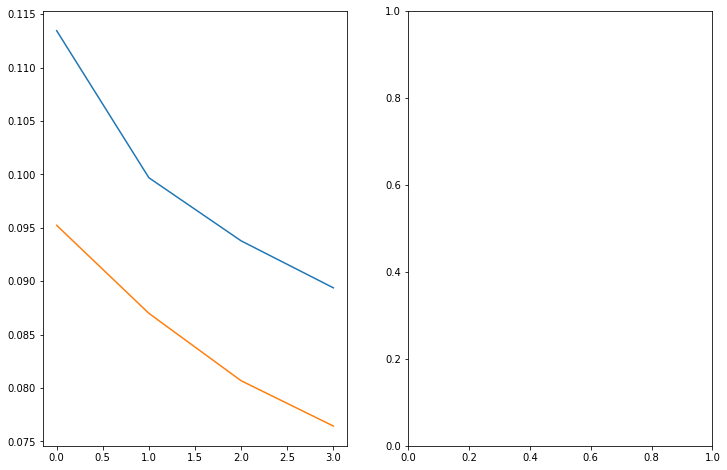

In [52]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.subplot(1,2,2)
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Test Accuracy')
plt.show()

In [53]:
y_hat = model_treated.predict(X_test_treated,verbose=True)

375806/375806 [==============================] - 109s 289us/step


In [54]:
from sklearn.metrics import f1_score
pred_val_y = model_treated.predict([X_t_chk], batch_size=1024, verbose=1)
thresholds = []
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    res = f1_score(y_chk_treated, (pred_val_y > thresh).astype(int))
    thresholds.append([thresh, res])
    print("F1 score at threshold {0} is {1}".format(thresh, res))
    
thresholds.sort(key=lambda x: x[1], reverse=True)
best_thresh_1 = thresholds[0][0]
print("Best threshold: ", best_thresh_1)

#y_pred = model_treated.predict(X_test_treated, batch_size=1024, verbose=True)

130613/130613 [==============================] - 10s 80us/step
F1 score at threshold 0.1 is 0.641291617868496
F1 score at threshold 0.11 is 0.6522185175686074
F1 score at threshold 0.12 is 0.6615223646351034
F1 score at threshold 0.13 is 0.6708366604560376
F1 score at threshold 0.14 is 0.6779110670154235
F1 score at threshold 0.15 is 0.6857770858137192
F1 score at threshold 0.16 is 0.6939895794566432
F1 score at threshold 0.17 is 0.6997549019607843
F1 score at threshold 0.18 is 0.705119030580602
F1 score at threshold 0.19 is 0.711104670820654
F1 score at threshold 0.2 is 0.715961294106148
F1 score at threshold 0.21 is 0.7203042426038424
F1 score at threshold 0.22 is 0.7238009771662179
F1 score at threshold 0.23 is 0.727437641723356
F1 score at threshold 0.24 is 0.7311335166513901
F1 score at threshold 0.25 is 0.7345869297163994
F1 score at threshold 0.26 is 0.7372183372183372
F1 score at threshold 0.27 is 0.7401599498196644
F1 score at threshold 0.28 is 0.7435383479269965
F1 score at t

In [55]:
submission = pd.read_csv('../input/quora-insincere-questions-classification/sample_submission.csv', encoding='utf-8')

In [56]:
y_pred = (y_hat > best_thresh_1).astype(int)
submission['prediction'] = y_pred
submission.to_csv('submission.csv', index=False)